In [2]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

from matplotlib.markers import MarkerStyle
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [3]:
from scipy.optimize import curve_fit

In [4]:
import sys
sys.path.append('../')  # go to parent dir
sys.path.append('/home/artem/git/sdafe-utils')

In [5]:
from sdafe.ch09.ols import reduce_model

### 11.12.1 Nonlinear Regression

In [6]:
data = pd.read_csv('../data/Irates.csv', index_col=0)
data.head()

,r1,r2,r3,r5,r6,r11,r12,r36,r60,r120
Year,,,,,,,,,,
1946.916667,0.325,0.422,0.477,0.549,0.577,0.698,0.720,1.145,1.415,1.825
1947.000000,0.322,0.427,0.485,0.555,0.583,0.698,0.718,1.119,1.386,1.824
1947.083333,0.326,0.419,0.473,0.543,0.571,0.693,0.715,1.140,1.406,1.817
1947.166667,0.318,0.441,0.508,0.583,0.610,0.718,0.737,1.105,1.364,1.804
1947.250000,0.302,0.445,0.521,0.606,0.637,0.759,0.780,1.172,1.416,1.815


#### Problem 1

We use 1-month interest rates (annualised) from United States sampled monthly. The values are expressed as percentages.

In [7]:
r1 = data['r1']

In [8]:
lag_r1 = r1.shift().dropna()
delta_r1 = r1.diff().dropna()

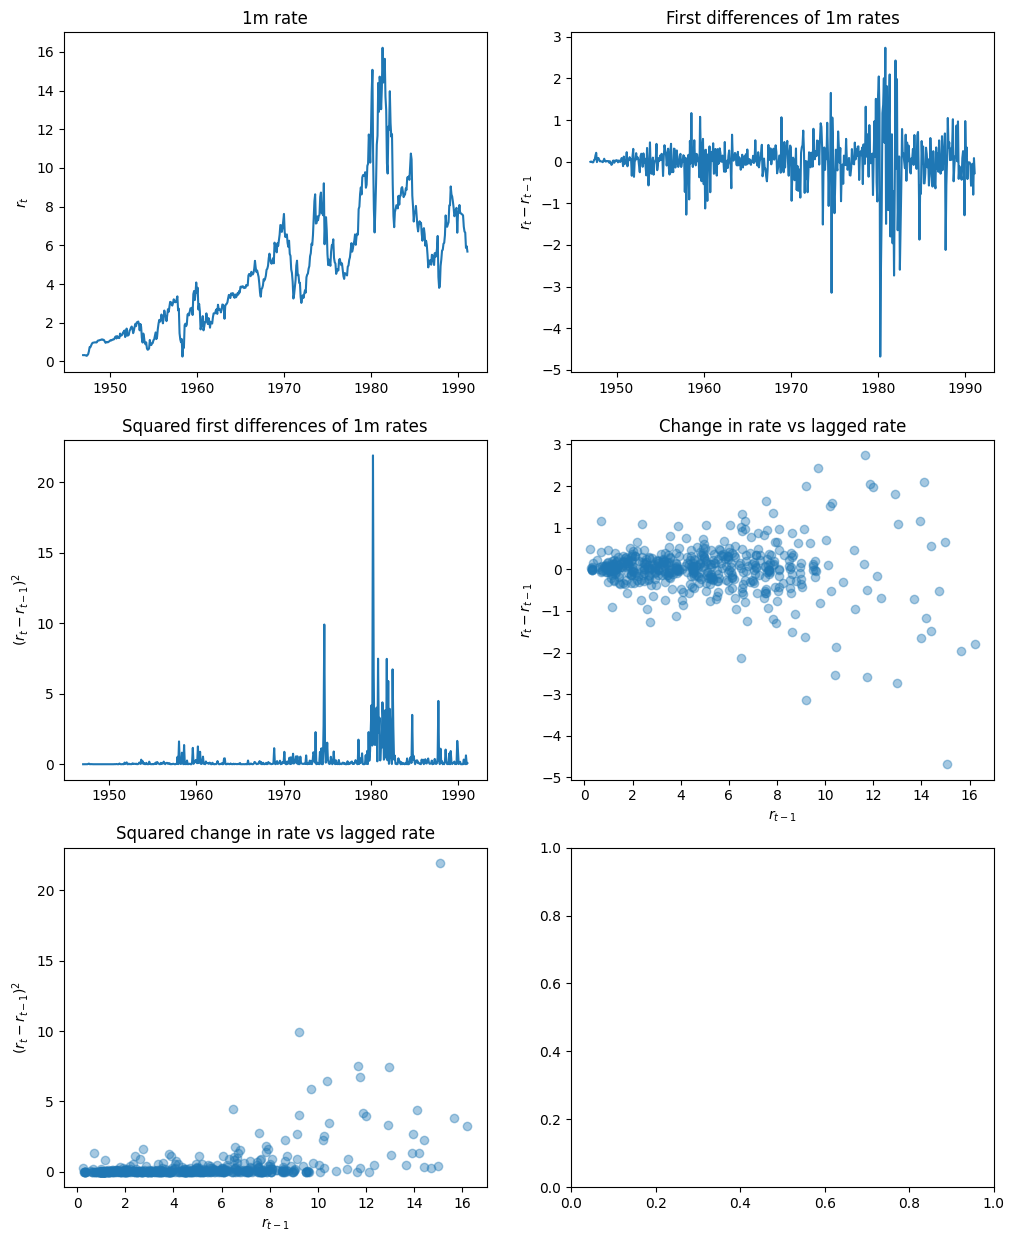

In [9]:
fig, axs = plt.subplots(3, 2, figsize=(12, 15))

axs[0][0].plot(r1);
axs[0][0].set_title('1m rate');
axs[0][0].set_ylabel('$r_t$');

axs[0][1].plot(delta_r1);
axs[0][1].set_title('First differences of 1m rates');
axs[0][1].set_ylabel('$r_t - r_{t-1}$');

axs[1][0].plot(delta_r1 ** 2);
axs[1][0].set_title('Squared first differences of 1m rates');
axs[1][0].set_ylabel('$(r_t - r_{t-1})^2$');

axs[1][1].scatter(lag_r1, delta_r1, alpha=0.4);
axs[1][1].set_title('Change in rate vs lagged rate');
axs[1][1].set_xlabel('$r_{t-1}$');
axs[1][1].set_ylabel('$r_t - r_{t-1}$');

axs[2][0].scatter(lag_r1, delta_r1 ** 2, alpha=0.4);
axs[2][0].set_title('Squared change in rate vs lagged rate');
axs[2][0].set_xlabel('$r_{t-1}$');
axs[2][0].set_ylabel('$(r_t - r_{t-1})^2$');

#### Problem 2

There is no visually apparent trend in the plot of differences against lagged values.

#### Problem 3

In [10]:
def mu(r, a, theta):
    return a * (theta - r)

In [11]:
fit = curve_fit(mu, lag_r1, delta_r1, p0=[0.01, 5])

The estimates of $a$ and $\theta$ are:

In [12]:
fit[0]

array([0.01983913, 5.32754114])

The 95% confidence intervals are:

In [13]:
def conf_int(fit, conf=0.95):
    q = stats.norm.ppf(1 - (1 - conf) / 2)
    return fit[0].reshape(-1, 1) + np.sqrt(np.diag(fit[1])).reshape(-1, 1) * q * np.array([-1, 1])

In [14]:
conf_int(fit)

array([[3.72856322e-03, 3.59497027e-02],
       [2.70174834e+00, 7.95333394e+00]])

#### Problem 4

In [15]:
res_sq = (delta_r1 - mu(lag_r1, *fit[0])) ** 2

In [16]:
def sigma(r, A, B):
    return A * r ** B

In [17]:
fit2 = curve_fit(sigma, lag_r1, res_sq, p0=[0.2, 0.5])

The estimates of $A$ and $B$ are:

In [18]:
fit2[0]

array([1.29976164e-03, 2.97322790e+00])

The 95% confidence intervals are:

In [19]:
conf_int(fit2)

array([[-3.79254481e-04,  2.97877776e-03],
       [ 2.46505194e+00,  3.48140386e+00]])

#### Problem 5

In [20]:
fit3 = curve_fit(mu, lag_r1, delta_r1, p0=[0.01, 5], sigma=np.sqrt(sigma(lag_r1, *fit2[0])))

The estimated values of $a$ and $\theta$ are now:

In [21]:
fit3[0]

array([0.06333301, 2.21528548])

with confidence intervals:

In [22]:
conf_int(fit3)

array([[0.02826479, 0.09840122],
       [1.22927826, 3.20129271]])

The estimate of $\theta$ obtained via weighted regression is lower as the values associated with higher rates also exhibit higher fluctuation, and so are downweighed in the regression.

However, it is difficult to assume reversion to a constant mean from the plot of the rates between 1946 and 1991.

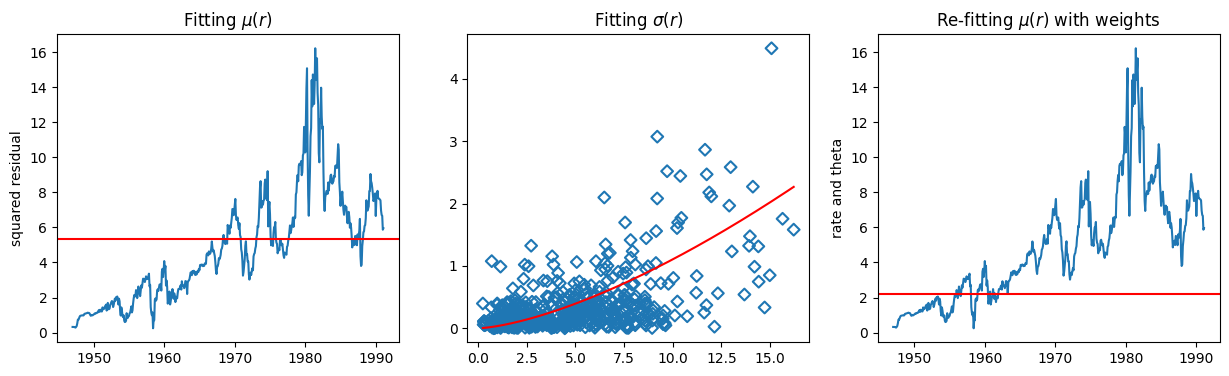

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(lag_r1);
axs[0].axhline(fit[0][1], color='red');
axs[0].set_ylabel('rate and theta');
axs[0].set_title('Fitting $\\mu(r)$');

xs = np.linspace(np.min(lag_r1), np.max(lag_r1), 200)
axs[1].scatter(lag_r1, np.sqrt(res_sq), marker=MarkerStyle('D', fillstyle='none'));
axs[1].plot(xs, np.sqrt(sigma(xs, *fit2[0])), color='red');
axs[0].set_ylabel('squared residual');
axs[1].set_title('Fitting $\\sigma(r)$');

axs[2].plot(lag_r1);
axs[2].axhline(fit3[0][1], color='red');
axs[2].set_ylabel('rate and theta');
axs[2].set_title('Re-fitting $\\mu(r)$ with weights');

### 11.12.2 Response Transformations

In [24]:
data = pd.read_csv('../data/HousePrices.csv')
data.head()

,price,lotsize,bedrooms,bathrooms,stories,driveway,recreation,fullbase,gasheat,aircon,garage,prefer
0,42000.0,5850,3,1,2,yes,no,yes,no,no,1,no
1,38500.0,4000,2,1,1,yes,no,no,no,no,0,no
2,49500.0,3060,3,1,1,yes,no,no,no,no,0,no
3,60500.0,6650,3,1,2,yes,yes,no,no,no,0,no
4,61000.0,6360,2,1,1,yes,no,no,no,no,0,no


In [25]:
for col in ['driveway', 'recreation', 'fullbase', 'gasheat', 'aircon', 'prefer']:
    data[col] = (data[col] == 'yes') * 1.0

In [26]:
data.head()

,price,lotsize,bedrooms,bathrooms,stories,driveway,recreation,fullbase,gasheat,aircon,garage,prefer
0,42000.0,5850,3,1,2,1.0,0.0,1.0,0.0,0.0,1,0.0
1,38500.0,4000,2,1,1,1.0,0.0,0.0,0.0,0.0,0,0.0
2,49500.0,3060,3,1,1,1.0,0.0,0.0,0.0,0.0,0,0.0
3,60500.0,6650,3,1,2,1.0,1.0,0.0,0.0,0.0,0,0.0
4,61000.0,6360,2,1,1,1.0,0.0,0.0,0.0,0.0,0,0.0


In [27]:
y = data.iloc[:, 0]
x = data.iloc[:, 1:]

In [28]:
model_def = sm.OLS(y, sm.add_constant(x))
model = model_def.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     99.97
Date:                Wed, 17 May 2023   Prob (F-statistic):          6.18e-122
Time:                        17:28:12   Log-Likelihood:                -6034.1
No. Observations:                 546   AIC:                         1.209e+04
Df Residuals:                     534   BIC:                         1.214e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4038.3504   3409.471     -1.184      0.237   -1.07e+04    2659.271
lotsize        3.5463      0.350     10.124      0.000       2.858       4.234
bedrooms    1832.0035   1047.000      1.750      0.081    -224.741    3888.748
bathrooms   1.434e+04   1489.921      9.622      0.000    1.14e+04    1.73e+04
stories     6556.9457    925.290      7.086      0.000    4739.291    8374.600
driveway    6687.7789   2045.246      3.270      0.001    2670.065    1.07e+04
recreation  4511.2838   1899.958      2.374      0.018     778.976    8243.592
fullbase    5452.3855   1588.024      3.433      0.001    2332.845    8571.926
gasheat     1.283e+04   3217.597      3.988      0.000    6510.706    1.92e+04
aircon      1.263e+04   1555.021      8.124      0.000    9578.182    1.57e+04
garage      4244.8290    840.544      5.050      0.000    2593.650    5896.008
prefer      9369.5132   1669.091      5.614      0.000    6090.724    1.26e+04
==============================================================================
Omnibus:                       93.454   Durbin-Watson:                   1.604
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              247.620
Skew:                           0.853   Prob(JB):                     1.70e-54
Kurtosis:                       5.824   Cond. No.                     3.07e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
def loglik_f(alpha):
    y_tr = y / np.exp(np.mean(np.log(y)))
    y_tr = stats.boxcox(y_tr, alpha)
    model_def = sm.OLS(y_tr, sm.add_constant(x))
    model = model_def.fit()
    return -model.nobs / 2 * np.log(model.ssr)

In [30]:
xs = np.linspace(-2, 2, 100)
l = np.fromiter((loglik_f(alpha) for alpha in xs), float)

The MLE estimate of $\theta$ is:

In [31]:
alpha_hat = xs[np.argmax(l)]
alpha_hat

0.14141414141414144

and the confidence interval:

In [32]:
conf = 0.95
conf_l = np.max(l) - stats.chi2.ppf(conf, df=1) / 2
conf_int = xs[l >= conf_l][[0, -1]]
conf_int

array([0.02020202, 0.26262626])

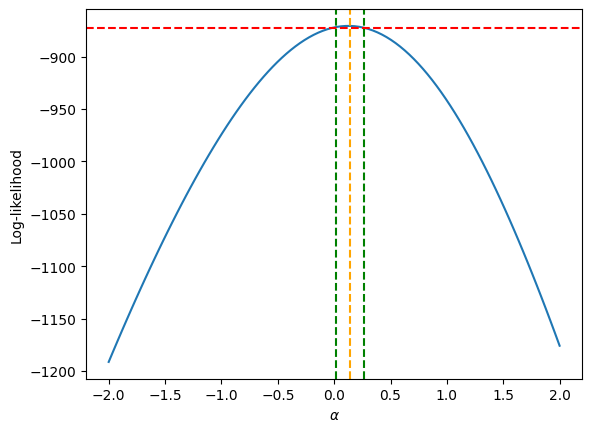

In [33]:
fig, ax = plt.subplots()
ax.plot(xs, l);
ax.axhline(conf_l, color='red', linestyle='--');
ax.axvline(xs[np.argmax(l)], color='orange', linestyle='--');
ax.axvline(conf_int[0], color='green', linestyle='--');
ax.axvline(conf_int[1], color='green', linestyle='--');
ax.set_xlabel('$\\alpha$');
ax.set_ylabel('Log-likelihood');

#### Problem 7

In [34]:
model_tr = sm.OLS(stats.boxcox(y, alpha_hat), sm.add_constant(x)).fit()
model_tr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     104.0
Date:                Wed, 17 May 2023   Prob (F-statistic):          4.80e-125
Time:                        17:28:20   Log-Likelihood:                -778.57
No. Observations:                 546   AIC:                             1581.
Df Residuals:                     534   BIC:                             1633.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.7911      0.225     96.804      0.000      21.349      22.233
lotsize        0.0002   2.31e-05     10.521      0.000       0.000       0.000
bedrooms       0.1583      0.069      2.289      0.022       0.022       0.294
bathrooms      0.8305      0.098      8.443      0.000       0.637       1.024
stories        0.4453      0.061      7.289      0.000       0.325       0.565
driveway       0.6044      0.135      4.476      0.000       0.339       0.870
recreation     0.3504      0.125      2.793      0.005       0.104       0.597
fullbase       0.4626      0.105      4.412      0.000       0.257       0.669
gasheat        0.8626      0.212      4.061      0.000       0.445       1.280
aircon         0.8585      0.103      8.362      0.000       0.657       1.060
garage         0.2495      0.055      4.497      0.000       0.141       0.359
prefer         0.6157      0.110      5.587      0.000       0.399       0.832
==============================================================================
Omnibus:                        4.321   Durbin-Watson:                   1.529
Prob(Omnibus):                  0.115   Jarque-Bera (JB):                5.142
Skew:                          -0.063   Prob(JB):                       0.0765
Kurtosis:                       3.459   Cond. No.                     3.07e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The transformed model offers a substantial improvement in fit compared to the original model.

In [35]:
model.aic

12092.187991373587

In [36]:
model_tr.aic

1581.1447592387458

#### Problem 8

We can see that the heteroskedasticity in the residuals is significantly reduced.

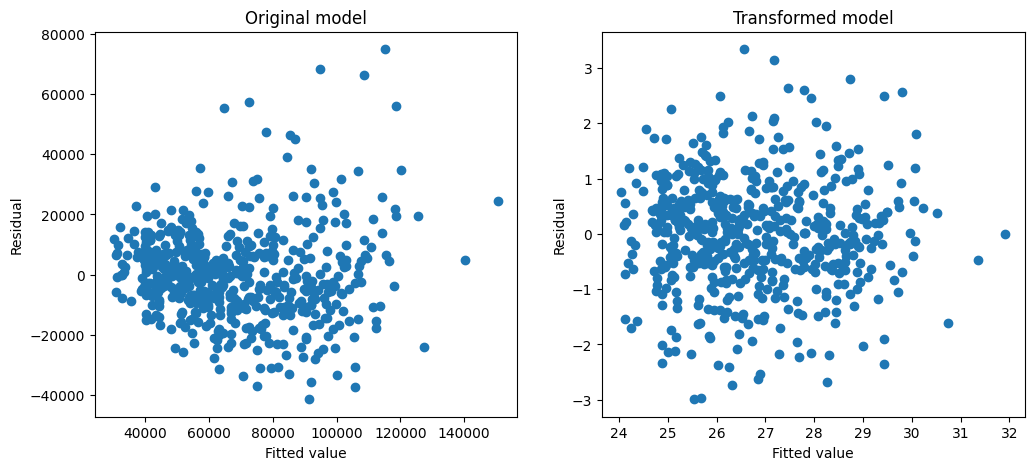

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(model.fittedvalues, model.resid);
axs[0].set_title('Original model');
axs[0].set_xlabel('Fitted value');
axs[0].set_ylabel('Residual');

axs[1].scatter(model_tr.fittedvalues, model_tr.resid);
axs[1].set_title('Transformed model');
axs[1].set_xlabel('Fitted value');
axs[1].set_ylabel('Residual');

### 11.12.3 Binary Regression: Who Owns an Air Conditioner

In [38]:
x = data.drop('aircon', axis=1)
y = data['aircon']

In [39]:
fit = sm.GLM(y, sm.add_constant(x), family=sm.families.Binomial()).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 aircon   No. Observations:                  546
Model:                            GLM   Df Residuals:                      534
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -262.53
Date:                Wed, 17 May 2023   Deviance:                       525.05
Time:                        17:28:28   Pearson chi2:                     765.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2497
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5756      0.597     -5.992      0.000      -4.745      -2.406
price        5.45e-05   8.01e-06      6.803      0.000    3.88e-05    7.02e-05
lotsize    -4.482e-05   6.23e-05     -0.719      0.472      -0.000    7.73e-05
bedrooms      -0.0673      0.175     -0.385      0.700      -0.410       0.275
bathrooms     -0.5587      0.271     -2.065      0.039      -1.089      -0.028
stories        0.3155      0.154      2.048      0.041       0.014       0.617
driveway      -0.4089      0.355     -1.152      0.249      -1.105       0.287
recreation     0.1052      0.297      0.355      0.723      -0.476       0.687
fullbase       0.0178      0.261      0.068      0.946      -0.493       0.529
gasheat       -3.9291      1.121     -3.506      0.000      -6.125      -1.733
garage         0.0689      0.137      0.502      0.616      -0.200       0.338
prefer        -0.3294      0.274     -1.201      0.230      -0.867       0.208
==============================================================================
"""

In [40]:
remaining_cols = reduce_model(x, y, lambda x, y: sm.GLM(y, x, family=sm.families.Binomial()).fit())

Variables: ['price', 'lotsize', 'bedrooms', 'bathrooms', 'stories', 'driveway', 'recreation', 'fullbase', 'gasheat', 'garage', 'prefer']
                   AIC
fullbase    547.057899
recreation  547.178778
bedrooms    547.202513
garage      547.303735
lotsize     547.575729
driveway    548.338304
prefer      548.521763
<none>      549.053259
stories     551.291424
bathrooms   551.528033
gasheat     574.336891
price       607.284688
Dropping variable: fullbase

Variables: ['price', 'lotsize', 'bedrooms', 'bathrooms', 'stories', 'driveway', 'recreation', 'gasheat', 'garage', 'prefer']
                   AIC
bedrooms    545.203483
recreation  545.218333
garage      545.306797
lotsize     545.606822
driveway    546.343813
prefer      546.542218
<none>      547.057899
bathrooms   549.528163
stories     549.724471
gasheat     572.336914
price       606.612242
Dropping variable: bedrooms

Variables: ['price', 'lotsize', 'bathrooms', 'stories', 'driveway', 'recreation', 'gasheat', 'garage', 'p

In [41]:
fit = sm.GLM(y, sm.add_constant(x[remaining_cols]), family=sm.families.Binomial()).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 aircon   No. Observations:                  546
Model:                            GLM   Df Residuals:                      541
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -264.68
Date:                Wed, 17 May 2023   Deviance:                       529.36
Time:                        17:28:44   Pearson chi2:                     661.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2438
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.0448      0.405     -9.987      0.000      -4.839      -3.251
price       4.782e-05   6.01e-06      7.959      0.000     3.6e-05    5.96e-05
bathrooms     -0.4723      0.258     -1.833      0.067      -0.977       0.033
stories        0.3224      0.132      2.449      0.014       0.064       0.580
gasheat       -3.6568      1.082     -3.378      0.001      -5.778      -1.535
==============================================================================
"""

#### Problem 9

The effect of `price` and `gasheat` on the response variable is highly significant. The effect of `stories` is significant at 95% confidence. The effect of `bathrooms` is not significant at 95% confidence level - this variable could also be eliminated from the model.

Qualitatively, the probability of owning an air conditionining increases with price and the number of stories and decreases with the presence of gas heating.